# Homework #7: Solutions
## Hamiltonian Monte Carlo for Bayesian Logistic Regression

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2020**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
import autograd.numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.preprocessing import PolynomialFeatures
from pymc3 import Model
import pymc3 as pm
import matplotlib.pyplot as plt
import sys
%matplotlib inline

ModuleNotFoundError: No module named 'autograd'

In [207]:
N = 4000
sigma_z = 1**0.5
sigma_y = 0.1**0.5
w_0 = 1
w_1 = 1.5
w_2 = 2.
w_3 = 0.5
x = np.random.normal(0, sigma_z, N)
z = np.random.normal(0, sigma_z, N)
# f = lambda x, z: w_0 + w_2 * z + w_3 * x * z + w_1 * x 
f = lambda x, z: w_1 * (x + z)**3 / 30.
# f_prime = lambda x, z: 1.34 * (x + z)**2 / 10.
y = f(x, z) + np.random.normal(0, sigma_y, N)
# y_prime = f_prime(x, z) + np.random.normal(0, sigma_y, N)

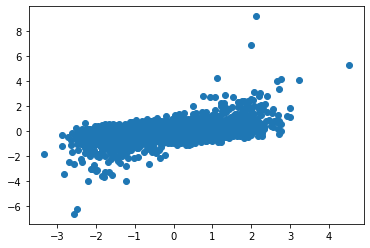

In [208]:
plt.scatter(x.flatten(), y.flatten())
# plt.scatter(x.flatten(), y_prime.flatten(), color='red', alpha=0.1)

In [209]:
# Sample from the posterior of the Bayesian logistic regression model with degree 2 features
var = 1.
with pm.Model() as bayesian_model:
    #define priors
#     w_3 = pm.Normal('w_3', mu=0, tau=1./var)
#     w_2 = pm.Normal('w_2', mu=0, tau=1./var)
    w_1 = pm.Normal('w_1', mu=0, tau=1./var)
#     w_0 = pm.Normal('w_0', mu=0, tau=1./var)
    z = pm.Normal('zs', mu=0, tau=1./sigma_z**2, shape=N)
    
    
    #define linear model, using marital status as a covariate
    mu = w_1 * (x + z)**3 / 30.

    #define binomial likelihood
    y_observed = pm.Normal('y_obs', mu=mu, tau=1./sigma_y**2, observed=y)

    trace = pm.sample(30000, tune=8000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [zs, w_1]


Sampling 2 chains for 8_000 tune and 30_000 draw iterations (16_000 + 60_000 draws total) took 356 seconds.
The number of effective samples is smaller than 25% for some parameters.


/opt/anaconda3/envs/autograd/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


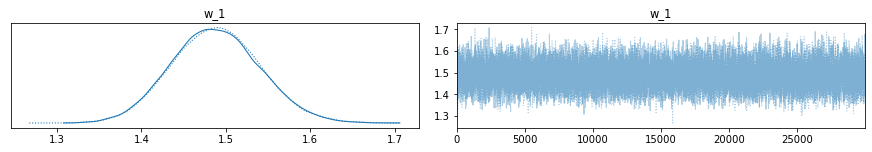

In [210]:
# Convergence checks
pm.traceplot(trace, var_names=['w_1'])
plt.show()

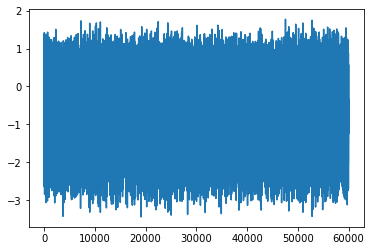

In [211]:
S = 300
plt.plot(np.arange(trace['zs'].shape[0]), trace['zs'].T[S])


In [212]:
np.mean(trace['w_1'])

1.4881945200405342

In [2]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5
        
    i = 0
    
    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)
        
        i += 1
        
    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
        
    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def predict(self, x):
        y = sigmoid(x.dot(self.slopes) + self.intercept)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

## Problem Description: Inference for Bayesian Logistic Regression Models
In In-Class Exercise 10.13, we studied the problem of how to evaluate the classification probabilites outputed by a Logistic Regression model using calibration plots. Calibration plots are computed using observed data (data that is part of or similar to our training set). In this homework, we evaluate the usefulness of the predictive uncertainties Logistic Regression models and Bayesian Logistic models for test data that are dissimilar to our training data. These test data points are called ***out of distribution (OOD) points***. Just as in Homework #2, we want the predictive uncertainties from our models to help us distinguish ***in-distribution*** test data (test data that are similar to data on which we trained our model) and OOD test data. Again, in many safety-critical applications of ML, we want human-experts to override model decisions if the model is operating on extremely unfamiliar data.


### Part I: Interpreting the Classification Probabilites of Logistic Regression as Uncertainties

**Exercise 1: (The Need for Useful Uncertainties in Classification)** Explain why OOD detection may be crucial for classifiers deployed in risk-adverse applications. Be concrete: choose a real-life domain application, identify the real-life consequences of an incorrect classification, explain *exactly* how OOD detection can help mitigate the risk of an incorrect classification. Feel free to use the following list of articles to help construct your answer.

**Reference:**
1. [Facial Recognition Is Accurate, if You’re a White Guy](https://www.nytimes.com/2018/02/09/technology/facial-recognition-race-artificial-intelligence.html)
2. [IBM Builds a More Diverse Million-Face Dataset to Help Reduce Bias in AI](https://techcrunch.com/2019/01/29/ibm-builds-a-more-diverse-million-face-dataset-to-help-reduce-bias-in-ai/)
3. [Wrongfully Accused by an Algorithm](https://www.nytimes.com/2020/06/24/technology/facial-recognition-arrest.html)
4. [Gender imbalance in medical imaging datasets produces biased classifiers for computer-aided diagnosis](https://www.pnas.org/content/pnas/early/2020/05/19/1919012117.full.pdf)

**Solutions:** In the papers linked above, we see two examples of ML algorithms (classifiers in particular) causing **disparate impact** (see definition in Lecture #13) in real-life settings: automatic diagnostics and facial recognition for law enforcement. In both cases, existing research shows that dataset imbalance (the fact that the training data does not contain sufficient or representative examples of specific subgroups of the population) may be partly responsible for the observed bias of the models - when the model is shown a test data point that is very different from model's training data, it is liable to give incorrect but extremely confident predictions. For example, classifiers that are trained to distinguish CT scans of cancerous tissues from healthy tissues may give an incorrect but extremely confident label for a scan of inflamed tissue (since this type of image is not present in the training data). This is a case where OOD detection **may** help, if we detect that a test dat point is likely OOD (e.g. a type of image that is not included in the training set), a human decision maker can override the model's decision in this case.

**Exercise 2: (Classifying OOD MNIST Digits)** In In-Class Exercise 10.13, we interpreted the output of a Logistic Regression model - the classification probability - as an indicator of the confidence of the model when it is classifying a specific data point (e.g. when the probability is close to 0.5, we say that the model is not confident in classifying the data point as class 1 or 0). Explain why this is a reasonable interpretation of the classification probability. 

In this Exercise, build a Logistic Regression model to distinguish between digital images of handwritten digits (this is the MNIST dataset):

` LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)`

For simplicity, we only look at images of digits: 1 and 6. 

In this dataset, the classes are balanced (we take 600 images of each digit). Report the accuracy of your trained classifier, based on this, decide whether or not this is a good model.

Next, for the predefined set of six test images,
`test_point_1`, ..., `test_point_6`,
report the classification probabiliy for each image under your trained model. Interpreting these probabilities as uncertainty, i.e. model confidence, do these predictive uncertainties make sense? **Hint:** compare the predictive uncertainties to the visualizations of these test images.

So is this classifier a good model? Does your analysis of the model's performance via its predictive accuracy agree with your analysis of the model's performance via its predictive uncertainties? Conclude whether or not you would feel comfortable using this model in a real-life setting?

**Solutions:**

In [3]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
# Pick out two classes of digits: 1, 6 and take a subset of samples
X_subset = X[((y == '1') | (y == '6'))][0:600]
y_subset = y[((y == '1') | (y == '6'))][0:600]

# Encode the label '1' with y=1, and the label '6' with y=0
y_subset[y_subset == '1'] = 1
y_subset[y_subset == '6'] = 0
y_subset = y_subset.astype(int)

In [5]:
# Randomize our data
random_state = check_random_state(0)
permutation = random_state.permutation(X_subset.shape[0])
X_subset = X_subset[permutation]
y_subset = y_subset[permutation]
X_subset = X_subset.reshape((X_subset.shape[0], -1))

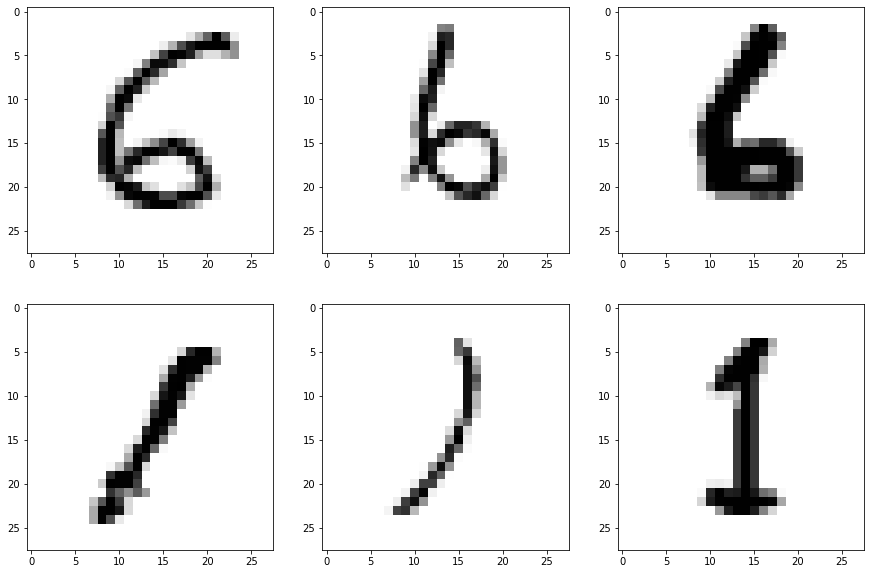

In [6]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    ax[0, i].imshow(X_subset[y_subset == 0][i].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[1, i].imshow(X_subset[y_subset == 1][i].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [7]:
# Test images for evaluating your classifier
test_point_1 = X_subset[y_subset == 0][10]
test_point_2 = X_subset[y_subset == 1][10]
test_point_3 = X[y=='3'][20]
test_point_4 = np.random.normal(200, 10, size=(28 * 28, ))
test_point_5 = test_point_2 + np.random.normal(300, 10, size=(28 * 28, )) - test_point_1
test_point_6 = test_point_2 + test_point_1 + np.random.normal(100, 10, size=(28 * 28, ))

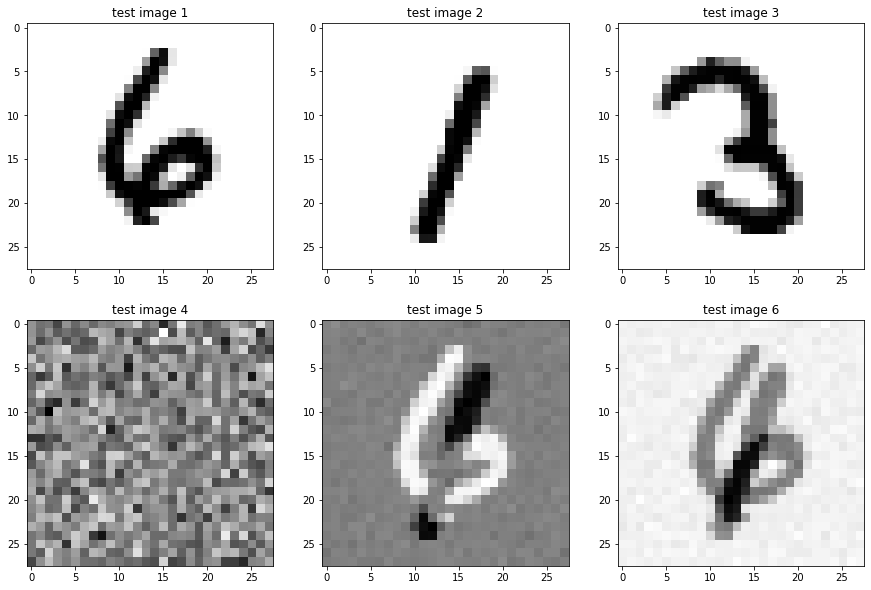

In [8]:
# Visualize some samples from the test dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(test_point_1.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 0].set_title('test image 1')
ax[0, 1].imshow(test_point_2.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 1].set_title('test image 2')
ax[0, 2].imshow(test_point_3.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 2].set_title('test image 3')
ax[1, 0].imshow(test_point_4.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 0].set_title('test image 4')
ax[1, 1].imshow(test_point_5.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 1].set_title('test image 5')
ax[1, 2].imshow(test_point_6.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 2].set_title('test image 6')
plt.show()

We first fit a logistic regression model to our training data.

In [9]:
# Fit a logistic regression model on training data
logistic = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
logistic.fit(X_subset, y_subset)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.1, verbose=0,
                   warm_start=False)

This is a case where we can't visualize our actual dataset and so we can't visualize the decision boundary. So we compute the accuracy of our trained classifier (note that since the classes are balanced, accuracy is a good metric for model performance).

In [10]:
print('Accuracy of the logistic regression model: ', logistic.score(X_subset, y_subset))

Accuracy of the logistic regression model:  0.9933333333333333


We see that our logistic regression model is highly accurate, so even though we can't visualize the decision boundary, we can image that the images of `1` and the images of `6` are probably easily separated with a line (linear separable). So this is good right?

Well, the problem is that we don't always use models under the same conditions under which they are built - specifically, even though the model was trained on `1`'s and `6`'s, when the model is being deployed it might be asked to classify images of `2`'s or `3`'s or images of other objects all together (i.e. out of distribution data or data with covariate shift)! So what happens when we show OOD images to our classifier? 

Let's evaluate our classifier's output (the classification probability) at our OOD points.

In [11]:
# Compute the classification probabilities for the test images
data = np.vstack((logistic.predict_proba(test_point_1.reshape((1, -1))), 
                  logistic.predict_proba(test_point_2.reshape((1, -1))),
                  logistic.predict_proba(test_point_3.reshape((1, -1))),
                  logistic.predict_proba(test_point_4.reshape((1, -1))),
                  logistic.predict_proba(test_point_5.reshape((1, -1))),
                  logistic.predict_proba(test_point_6.reshape((1, -1)))))

pd.DataFrame(data, columns=['Probability of Digit 6', 'Probability of Digit 1'], 
             index=['test point 1', 'test point 2', 'test point 3', 'test point 4', 'test point 5', 'test point 6'])

,Probability of Digit 6,Probability of Digit 1
test point 1,0.999167,0.000833
test point 2,0.002433,0.997567
test point 3,0.141917,0.858083
test point 4,0.994480,0.005520
test point 5,0.004091,0.995909
test point 6,0.974144,0.025856


We see that our logistic regression model classifies test point 1 as a `6` with nearly 100% probability, this makes sense since the image looks very much like a typical `6`. The model classifies the second test point as a `1` with nearly 100% probability (i.e. the classification probability for a `6` is nearly 0 percent), this also makes sense. Test point 3, however, is an image of a `3`, which the classifier confidently classifies as a digit `1`. Test point 4 is an image of random Gaussian noise, which the classifier classifies as a digit `6` with nearly 100% probability. Test point 5 is a superposition of a `1` and a `6`, with the `6` rendered in negative contrast, this image is classified as a `1` with near 100% probability. Finally, test point 6 is a superposition of a `1` and a `6`, with both images in positive contrast, and the classifier classifies this as a `6` with near 100% probability. 

We see that in cases of test points 3-6 the classifier is making not only incorrect, but nonsensical classifications and is doing so with near perfect confidence. This type of errors are especially insidious! Why? Because:
1. the model has extremely good performance on data that looks like training data, digits `1` and `6`, so engineers or practitioners may be more inclined to accept the model's decisions.
2. in a typical application, an engineer or a practitioner might check test points for which the classification probability is close to 50%, but will interpret a classification of 100% and 0% as more likely to be correct (because the model is more confident).

You might say that this problem is simple to solve: if the model is trained on `1`'s and `6`'s, then let people know that images of `3`'s, `4`'s and other objects are out-of-distribution and should not be fed into the model! 

But can you always know what is out-of-distribution? That is, let say that you trained a classifier to distinguish people from inanimate objects in images and your training data consisting of millions of scraped photographs does not contain enough images of children (i.e. children are OOD). Then it is likely that when shown an image of a child your classifier will confidently classify the child as an inanimate object with perfect confidence. Unlike in the case of training a classifier only on digits `1` and `6`, here, you only know that your dataset contains images of people and so it's not obvious that images of a subgroup of people would be OOD - how on earth could you have known that your training data did not contain enough examples of children (is it practical to look at every image in your dataset)? If you think this scenario is purely hypothetical, it is not, for example see the controversy that followed Google's introduction of an automatic image annotation feature (https://www.bbc.com/news/technology-33347866).

But why would a classifier be so confident when it's so wrong on OOD points? We explore a possible reason in the following exercise.

**Exercise 3: (Classifying OOD Data for a Toy Dataset)** In this Exercise, build a Logistic Regression model to distinguish between two classes in our toy classification dataset:

` LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)` 

In this dataset, the classes are balanced (we have 100 points in each class). Report the accuracy of your trained classifier, based on this, decide whether or not this is a good model.

Next, for the predefined set of test points,
`test_points`,
report the classification probabiliy for each test point under your trained model. Interpreting these probabilities as uncertainty, i.e. model confidence, do these predictive uncertainties make sense? **Hint:** compare the predictive uncertainties to the visualizations of these test points, identify which of these test points are in-distribution and which ones are OOD.

Relate your analysis of the behaviour of Logistic Regression on this toy dataset to its performance on MNIST. Can you come up with some hypotheses for exactly when the classification probability indicates an inappropriate amount of certainty when predicting on test points?

**Solution:** The problem with logistic regression on MNIST is that we can't visualize the data or the decision boundary and so it is hard to conjecture wherein lies the source of the over-confidence of the model. In this problem, we consider a simple toy dataset with test points that are in-distribution and out-of-distribution and we will try to recreate the problems we observed on MNIST.

In [12]:
# Generate a toy dataset for classification
samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x = np.vstack((class_0, class_1))
y = np.array([0] * 100 + [1] * 100)

In [13]:
# Define test data points
test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]

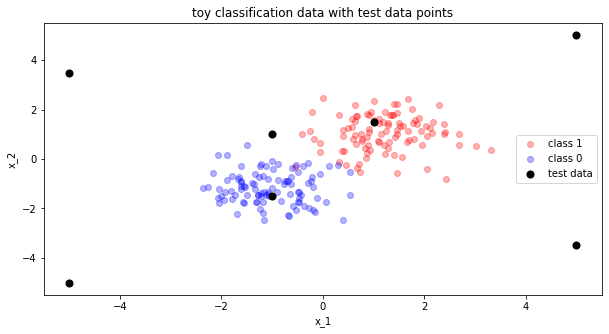

In [14]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()

Let's fit a logistic regression to our toy dataset.

In [15]:
# Fit a logistic regression model on the toy training data
logistic = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
logistic.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.1, verbose=0,
                   warm_start=False)

Again, we evaluate the accuracy of our model (note that since the classes are balanced, the accuracy is a good indicator of the model's performance).

In [16]:
print('Accuracy of the logistic regression model: ', logistic.score(x, y))

Accuracy of the logistic regression model:  0.985


Unlike before, this time we can actually visualize the decision boundary of the learned model! Both the decision boundary and the accuracy indicate that the learned logistic regression model fits the data well!

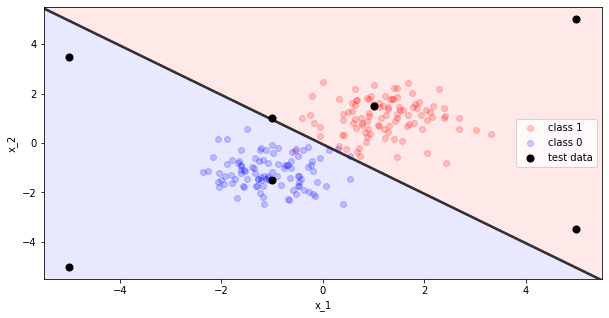

In [17]:
# Plot the decision boundary for the learned model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(x, y, [logistic], ax, poly_degree=1, test_points=test_points, shaded=True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

Now let's see what are the classification probabilies for each of our chosen test points!

In [18]:
# Compute the classification probabilities of the test points
data = np.vstack([logistic.predict_proba(np.array(pt).reshape((1, -1))) for pt in test_points])
pd.DataFrame(data, columns=['Probability of Class 0', 'Probability of Class 1'], 
             index=[str(pt) for pt in test_points])

,Probability of Class 0,Probability of Class 1
"(-5, -5)",1.000000e+00,5.455256e-11
"(-5, 3.5)",9.705478e-01,2.945219e-02
"(5, 5)",4.847545e-11,1.000000e+00
"(5, -3.5)",2.625744e-02,9.737426e-01
"(-1, 1)",4.852710e-01,5.147290e-01
"(-1, -1.5)",9.971672e-01,2.832823e-03
"(1, 1.5)",2.518048e-03,9.974820e-01


We see that the model classifies the OOD points `(-5, 5)` and `(5, 5)` with near perfect confidence, and in this case, we actually see **why**: these two points are located far from the decision boundary, deep in the class 1 and class 0 regions of the input space repsectively, and since $p(y=1|x)$ increases and decreases with respect to the distance of $x$ and the decision boundary it makes sense that these two OOD points are given confident classifications. OOD points `(-5, 3.5)` and `(5, -3.5)` are also given confident classifications, but they are much closer to the decision boundary! This indicates that the model become quickly super confident just beyond the decision boundary! 

The in-distribution points `(-1, -1.5)` and `(1, 1.5)` are confidently classified, since each is surrounded by points of one class. 

The in-distribution point `(-1, 1)` is classified as class 1 with only a 60% probability since this point is located nearly on the decision boundary.

So should I be bothered that OOD points are classified with high confidence? In this case, since the points in the toy data have no real-life meaning and I don't know the true labels of the test poitns, I can't claim that the model's classifications of OOD points is incorrect. However, if the points in our dataset had been collected in some real-life context, then **the OOD points (points very far from the training data distribution) might have a very different real-life interpretation than the training data**! For example, if your training data consists of images of digits, these OOD points might be images of animals!

Our toy experiment gives us a way to understand the behaviour of the logistic regression model in Exercise 2. That is, the OOD images may be located far from the training images and hence far from the decision boundary, yielding extreme classification probabilities.


### Part II: Interpreting the Uncertainties of Bayesian Logistic Regression

**Exercise 4: (Classifying OOD Data for a Toy Dataset with Bayesian Logistic Regression)** 
In Exercise 2 and 3, we examined one source of uncertainty from a logistic model: the classification probability. There is another source of uncertainty: uncertainty over the model itself (which decision boundaries can fit the dataset).

Use your implementation of HMC from In-Class Exercise 10.20 to sample from the posterior of the following Bayesian Logistic Regression model for our toy dataset:

\begin{align}
w_i &\sim \mathcal{N}(0, 10)\\
Y^{(n)} &\sim Ber(\text{sigm}(w_2 X_1^{(n)} + w_1 X_2^{(n)} + w_0))
\end{align}

where $w_i$, $Y^{(n)}$, $X_i^{(n)}$ are real scalar valued random variables, and where the data consists of the observations $(x_1^{(n)}, x_2^{(n)}, y^{(n)})$ in our toy dataset $\mathcal{D}$.

Visualize the decision boundaries corresponding to the posterior samples from your Bayesian Logistic Regression model (see In-Class Exercise 10.13). What do the distribution of decision boundaries tell you about the model's predictive uncertainties for each of the test points (particularly the OOD points)?

**Solution:** In this homework solution set, we use `pymc3`'s implementation of HMC. Solution code for HMC implementation will be released after HW#9.

In [19]:
# Sample from the posterior of the Bayesian logistic regression model
var = 10.
with pm.Model() as bayesian_model:
    #define priors
    slopes = pm.Normal('slopes', mu=0, tau=1./var, shape=x.shape[1])
    intercept = pm.Normal('intercept', mu=0, tau=1./var)
    
    #define linear model, using marital status as a covariate
    mu = intercept + pm.math.dot(x, slopes) 
    #transform linear model into a probability
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    #define binomial likelihood
    y_observed = pm.Bernoulli('y_obs',  p=theta, observed=y)

    trace = pm.sample(4000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes]


Sampling 2 chains for 2_000 tune and 4_000 draw iterations (4_000 + 8_000 draws total) took 54 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/opt/anaconda3/envs/autograd/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


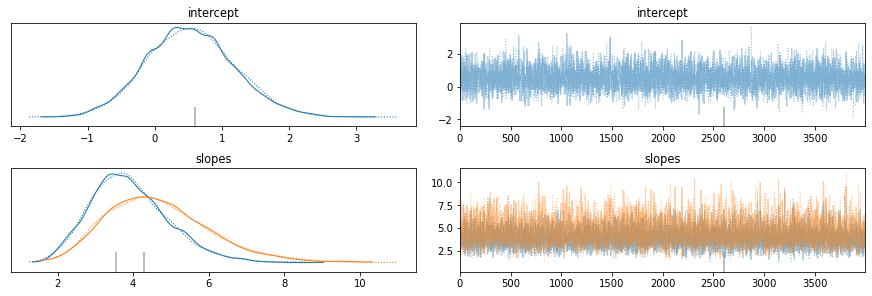

In [20]:
# Convergence checks
pm.traceplot(trace, var_names= ['intercept', 'slopes'])
plt.show()

It looks like our sampler has converged - or at least it's not obvious that it hasn't converged!

For each sample in the posterior of our Bayesian logistic regression model, we create a wrapper model that as the same API as `sklearn`'s logistic regression model, so that we can feed it into the `plot_decision_boundary` function.

In [21]:
# Build a model for each sample in the posterior
thinned_trace = trace[::10]
posterior_samples_index = np.random.choice(np.arange(len(thinned_trace)), size=100)
models = []

for index in posterior_samples_index:
    sample = thinned_trace[index]
    model = Bayesian_logistic_regression(sample['intercept'], sample['slopes'])
    models.append(model)

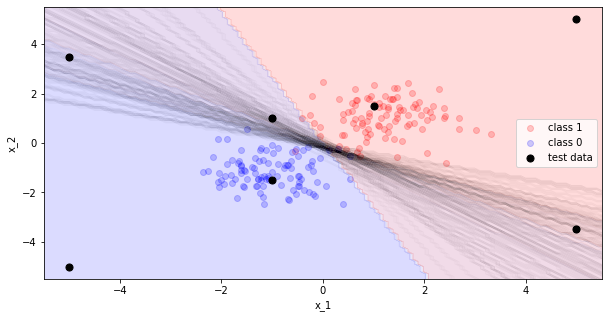

In [22]:
# Visualize the decision boundaries corresponding to the samples in the posterior
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(x, y, models, ax, test_points=test_points, poly_degree=1)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

From the visualization of the posterior samples as decision boundaries, we see that instead of finding a single "best" decision boundary, Bayesian logistic regression finds a distribution over plausible decision boundaries. This distribution quanitifies the model's uncertainty over which is be right decision boundary for the training data. Accordingly, we see that where there is a lot of data, the uncertainty over the boundary is low (i.e. the decision boundaries all more or less agree). However, far from the data in the negative diagonal direction, the uncertainty over decision boundaries grow, i.e. there are multiple ways of extrapolating the boundaries beyond the training data.

Since each decision boundary gives a different classification probability for each test point, the variance of these probabilities might be quite large for some points! For example, for the OOD points `(-5, 3.5)` and `(5, -3.5)` that are located close to the negative diagonal, we anticipate that the variance of the classfication probabilites of these points will be very high, since there are many very different possible decision boundaries near these points, and each will output very different classification probabilities (some of these boundaries are close to `(-5, 3.5)` and `(5, -3.5)` and some are far).

On the other hand, the OOD points `(-5, 5)` and `(5, 5)` are located far from all the decision boundaries and hence they would all be equally confident about these points - i.e. there will be little variance in the classification probabilities that these models output.

**Exercise 5: (Epistemic Uncertainty from Bayesian Logistic Regression)** Since the posterior $p(\mathbf{w} | \mathcal{D}))$ is a distribution over multiple models (i.e. decision boundaries) and each model outputs a classification probability for each test data point, the posterior $p(\mathbf{w} | \mathcal{D}))$ defines a distribution of classification probabilities for each test point. The variance of the distribution over classification probabilities is one way of quantifying the amount of ***epistemic uncertainty*** - uncertainty due to lack of observed training data - of the model at a particular test point.

Estimate the average epistemic uncertainty, under the posterior $p(\mathbf{w} | \mathcal{D}))$, of the data points in the toy data set, then estimate the epistemic uncertainty of each test data point. Interpret these uncertainties, in particular, explain to what extend can the epistemic uncertainties of this Bayesian Logistic Regression model be used to distinguish in-distribution points from OOD points. 

Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the posterior $p(\mathbf{w} | \mathcal{D}))$. Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Logistic Regression model is capable of distinguishing **all** possible OOD points.

**Solution:** We now formalize our intuition that variance in the classification probabilities coming from the models in the posterior can capture OOD points. We first compute the average classification probability variance under the posterior over the training data.

In [23]:
# Compute the average epistemic uncertainty over the trianing data
train_uncertainties = []
for pt in x:
    train_uncertainties.append(np.var([model.predict_proba(np.array(pt).reshape((1, -1))) for model in models]))
    
print('average epistemic uncertainty of training data:', np.mean(train_uncertainties))

average epistemic uncertainty of training data: 0.001522529265062677


Now, we compute the classification probability variance for each test point.

In [24]:
# Compute the epistemic uncertainty for test points
test_uncertainties = []
for pt in test_points:
    test_uncertainties.append(np.var([model.predict_proba(np.array(pt).reshape((1, -1))) for model in models]))

In [25]:
# Print the epistemic uncertainty for test points
pd.DataFrame(test_uncertainties, columns=['epistemic uncertainty'], 
             index=[str(pt) for pt in test_points])

,epistemic uncertainty
"(-5, -5)",1.169665e-21
"(-5, 3.5)",1.981041e-01
"(5, 5)",2.965066e-22
"(5, -3.5)",1.796864e-01
"(-1, 1)",7.399341e-02
"(-1, -1.5)",6.301581e-07
"(1, 1.5)",2.432171e-07


We see that the OOD points `(-5, 3.5)` and `(5, -3.5)` have epistemic uncertainty that is 40 to 60 times higher than the average epistemic uncertainty of the training data, indicating that these points may be located far from the training data. 

On the other hand, the point `(-1, 1)` is much closer to the training data but has 20 times higher epistemic uncertainty than the average epistemic uncertainty of the training data, indicating that this point may be OOD but is not as far from the data as `(-5, 3.5)` and `(5, -3.5)`.

Finally, the OOD points `(-5, -5)` and `(5, 5)` have nearly zero epistimic uncertainty under our posterior. In fact, the epistmic uncertainty of these two points are lower than the epistimic uncertainty of the two in-distribution points `(-1, -1.5)` and `(1, 1.5)`! 

So what does this mean? Does this mean that we cannot hope to identify OOD points using the notion of epistemic uncertainty? Well, not quite. Recall that the variance in classification probabilities comes from when different decision boundaries in the posterior outputing different probabilities. In Bayesian Logistic Regression, the decision boundaries are all linear and hence OOD points that are far from the training data in the positive diagonal direction will always be far from all the linear boundaries in the posterior (regardless of your choice of prior), and hence these points will always have low epistemic uncertainty! Another way of putting this: if you want to get high epistemic uncertainties for points like  `(-5, -5)` and `(5, 5)`, you'll need the decision boundaries in the posterior to curve around and go through these regions! That is, we need to use non-linear boundaries!

**Exercise 6: (Classifying OOD Data for a Toy Dataset with Bayesian Non-linear Logistic Regression)** 
Just as we can cast Bayesian Non-linear Regression as a non-linear transformation of the data followed by Bayesian Linear Regression, we can perform Bayesian Logistic Regression with non-linear decision boundaries by first applying a non-linear feature map to the data and then fitting a Bayesian Logistic Regression model on the features.

Perform Bayesian Logistic Regression using a degree 2 polynomial feature map, $\phi$, on the toy dataset. Use your implementation of HMC from In-Class Exercise 10.20 to sample from the posterior of the following Bayesian Logistic Regression model for our toy dataset:

\begin{align}
\mathbf{w} &\sim \mathcal{N}(0, 10\, \mathbf{I})\\
Y^{(n)} &\sim Ber(\text{sigm}(\mathbf{w}^\top \phi(\mathbf{X}^{(n)}) ))
\end{align}

Visualize the decision boundaries corresponding to the samples in the posterior. Are the epistemic uncertainties of this Bayesian model able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the posterior $p(\mathbf{w} | \mathcal{D}))$. Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Logistic Regression model is capable of distinguishing **all** possible OOD points.

**Solution:** Just as in kernel regression, we can perform Bayesian (or non-Bayesian) Logistic Regression with non-linear boundaries by first transforming our data through a non-linear **feature map** (see HW#2). Here we will use a degree 2 polynomial feature map.

In [26]:
# Augment the training data with degree 2 polynomial features
poly = PolynomialFeatures(2, include_bias=False)
x_poly = poly.fit_transform(x)

In [27]:
# Sample from the posterior of the Bayesian logistic regression model with degree 2 features
var = 10.
with pm.Model() as bayesian_model:
    #define priors
    slopes = pm.Normal('slopes', mu=0, tau=1./var, shape=x_poly.shape[1])
    intercept = pm.Normal('intercept', mu=0, tau=1./var)
    
    #define linear model, using marital status as a covariate
    mu = intercept + pm.math.dot(x_poly, slopes) 
    #transform linear model into a probability
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    #define binomial likelihood
    y_observed = pm.Bernoulli('y_obs',  p=theta, observed=y)

    trace = pm.sample(4000, tune=5000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes]


Sampling 2 chains for 5_000 tune and 4_000 draw iterations (10_000 + 8_000 draws total) took 103 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.


/opt/anaconda3/envs/autograd/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


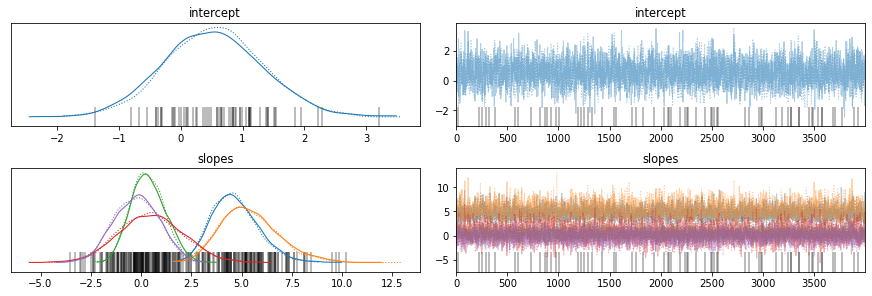

In [28]:
pm.traceplot(trace, var_names= ['intercept', 'slopes'])
plt.show()

In [29]:
# Build a model for each sample in the posterior
thinned_trace = trace[::10]
posterior_samples_index = np.random.choice(np.arange(len(thinned_trace)), size=100)
models = []

for index in posterior_samples_index:
    sample = thinned_trace[index]
    model = Bayesian_logistic_regression(sample['intercept'], sample['slopes'])
    models.append(model)

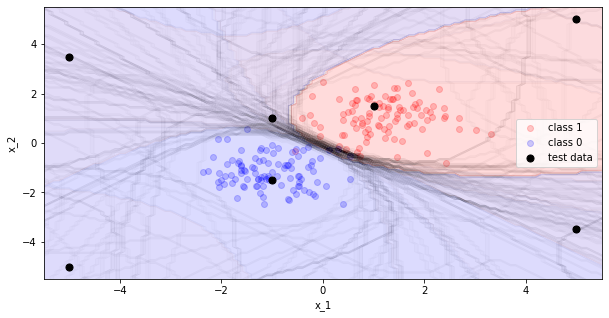

In [30]:
# Visualize the decision boundaries corresponding to the samples in the posterior
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(x, y, models, ax, test_points=test_points, poly_degree=2)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

In this case, we see that the models in the posterior have non-linear or curvy decision boundaries, and our OOD points are no longer located far away from all decision boundaries. Maybe this means that the epistemic uncertainties for these points will finally allow us to distinguish in-distribution vs OOD points! 

But there might be a problem: the decision boundaries seem to have a bias for curving towards the blue or class 0 region. Hence the OOD point `(-5, 5)` is a lot closer to the set of decision boundaries, but the OOD point `(5, -3.5)` is now much farther from this set of boundaries!

In [31]:
# Compute the epistemic uncertainty for test points
test_points_poly = poly.fit_transform(np.array(test_points))
test_uncertainties = []
for pt in test_points_poly:
    test_uncertainties.append(np.var([model.predict_proba(np.array(pt).reshape((1, -1))) for model in models]))

In [32]:
# Compute the average epistemic uncertainty over the trianing data
train_uncertainties = []
for pt in x_poly:
    train_uncertainties.append(np.var([model.predict_proba(np.array(pt).reshape((1, -1))) for model in models]))
    
print('average epistemic uncertainty of training data:', np.mean(train_uncertainties))

average epistemic uncertainty of training data: 0.0017706371298331315


In [33]:
# Print the epistemic uncertainty for test points
pd.DataFrame(test_uncertainties, columns=['epistemic uncertainty'], 
             index=[str(pt) for pt in test_points])

,epistemic uncertainty
"(-5, -5)",0.173787
"(-5, 3.5)",0.217316
"(5, 5)",0.158735
"(5, -3.5)",0.226154
"(-1, 1)",0.121354
"(-1, -1.5)",0.000001
"(1, 1.5)",0.000002


As we can see, the OOD points `(-5, -5)` and `(5, 5)` are now distinguishable from the training data since they have higher epistemic uncertainties, 100 times greater than the average epistemic uncertainty on the training data. 

But now the OOD points `(-5, 3.5)` and `(5, -3.5)` have similar or lower epistemic uncertainty that the average epistemic uncertainty on the training data. This is because the decision boundaries in the posterior curve away from these points. 

So again, we cannot distinguish all OOD points using epistemic uncertainty under the posterior of Bayeisan logistic regression with degree 2 polynomials!

**Exercise 7: (Classifying OOD Data for a Toy Dataset with Bootstrap Non-linear Logistic Regression)** Perform bootstrap Logistic Regression using a degree 2 polynomial feature map, $\phi$, on the toy dataset. Obtain 100 bootstrap Logistic Regression models:
`LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)`.

Visualize the decision boundaries corresponding to the samples in the bootstrap ensemble. Are the epistemic uncertainties of this ensemble able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries of the models in the ensemble. Using this geometric relationship, explain whether or not the epistemic uncertainties of our bootstrap ensemble is capable of distinguishing **all** possible OOD points.

**Solution:** Is the problem Bayesian inference? That is, what if we computed the epistemic uncertainty under an ensemble of boostrap models? Will we be able to distinguish OOD points vs in-distribution points?

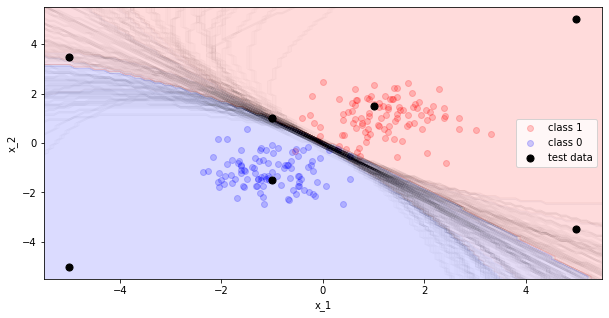

In [34]:
# Visualize the decision boundaries of the bootstrap models
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
models = []

for i in range(100):
    bootstrap_indices = np.random.choice(np.arange(0, len(y)), size=len(y))
    X_bootstrap = x_poly[bootstrap_indices]
    y_bootstrap = y[bootstrap_indices]
    logistic = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    logistic.fit(X_bootstrap, y_bootstrap)
    models.append(logistic)

ax = plot_decision_boundary(x, y, models, ax, test_points=test_points, poly_degree=2)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

Unfortunately, it does not look like the decision boundaries of this boostrap ensemble of degree 2 logistic regression models will help us distinguish OOD points. In particular, the OOD points located far from the data along the positive diagonal are sill far from the set of boundaries. Let's confirm by computing the epistemic uncertainty of these points.

In [35]:
# Compute the epistemic uncertainty for test points
test_points_poly = poly.fit_transform(np.array(test_points))
test_uncertainties = []
for pt in test_points_poly:
    test_uncertainties.append(np.var([model.predict_proba(np.array(pt).reshape((1, -1))) for model in models]))

In [36]:
# Compute the average epistemic uncertainty over the trianing data
train_uncertainties = []
for pt in x_poly:
    train_uncertainties.append(np.var([model.predict_proba(np.array(pt).reshape((1, -1))) for model in models]))
    
print('average epistemic uncertainty of training data:', np.mean(train_uncertainties))

average epistemic uncertainty of training data: 0.1940973993479041


In [37]:
# Print the epistemic uncertainty for test points
pd.DataFrame(test_uncertainties, columns=['epistemic uncertainty'], 
             index=[str(pt) for pt in test_points])

,epistemic uncertainty
"(-5, -5)",0.249931
"(-5, 3.5)",0.129487
"(5, 5)",0.249981
"(5, -3.5)",0.201146
"(-1, 1)",0.003133
"(-1, -1.5)",0.231016
"(1, 1.5)",0.226689


As expected the OOD points `(-5, -5)` and `(5, 5)` have epistemic uncertainty that is comparable to the in-distribution points `(-1, -1.5)` and `(1, 1.5)`. In fact, most of test points (in-dstribution or not) have similar epistemic uncertainty.

Again, since the variance in classification probability (epistemic uncertainty) comes from the decision boundaries in the posterior outputing very difference probabilites, in order to distinguish all OOD points, we need decision boundaries that curve around the training data in all directions (many of these boundaries need to encircle the data).

How are we going to get these circular boundaries? Do we need to use polynomials feature maps with higher degrees? You can try this out yourself.

In fact, obtaining accurate OOD detection is an active area of research in machine learning (many of your project papers are about this topic!). In particular, [BaCOUn](https://arxiv.org/pdf/2007.06096.pdf)  (pronouced "bacon") relates the task of OOD detection explicitly to the geometry to of the decision boundaries in the posterior of Bayesian classifiers.

**Exercise 8: (Classifying OOD Data for MNIST)** Fit a Bayesian Logistic Regression model on the MNIST data. Estimate the average epistemic uncertainty, under the posterior $p(\mathbf{w} | \mathcal{D}))$, of the data points in the training dataset, then estimate the epistemic uncertainty of each test image. Are the epistimic uncertainties from this model able to distinguish in-distribution points from OOD points?

You may need to use `pymc3`'s HMC sampler to obtain samples from $p(\mathbf{w} | \mathcal{D}))$, since your own implementation of HMC may very likely to be too slow. 

Why is HMC sampling slower for MNIST than it is for our toy classification data? Describe how well you expect HMC to scale for a Bayesian Logistic Regression model with degree $D$ polynomial features on MNIST? **Hint:** think about how many parameters are in the likelihood of a Bayesian Logistic Regression model with degree $D$ polynomial features. What does this say about the challenges of fitting Bayesian models to real-world datasets?

**Solution:** We've see that our Bayesian classifiers were not successful in distinguishing all possible OOD points from training data, but maybe such a classifier is already able to distinguish digits of `1` and `6` from non-sense images.

In [ ]:
# Sample from the posterior of the Bayesian logistic regression model with degree 2 features
var = 10.
with pm.Model() as bayesian_model:
    #define priors
    slopes = pm.Normal('slopes', mu=0, tau=1./var, shape=X_subset.shape[1])
    intercept = pm.Normal('intercept', mu=0, tau=1./var)
    
    #define linear model, using marital status as a covariate
    mu = intercept + pm.math.dot(X_subset, slopes) 
    #transform linear model into a probability
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    #define binomial likelihood
    y_observed = pm.Bernoulli('y_obs',  p=theta, observed=y_subset)

    trace = pm.sample(4000, tune=5000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes]


In [ ]:
# Build a model for each sample in the posterior
thinned_trace = trace[::10]
posterior_samples_index = np.random.choice(np.arange(len(thinned_trace)), size=100)
models = []

for index in posterior_samples_index:
    sample = thinned_trace[index]
    model = Bayesian_logistic_regression(sample['intercept'], sample['slopes'])
    models.append(model)

In [ ]:
# Compute the epistemic uncertainty for test points
test_points = [test_point_1, test_point_2, test_point_3, test_point_4, test_point_5, test_point_6]
test_uncertainties = []
for pt in test_points:
    test_uncertainties.append(np.var([model.predict_proba(np.array(pt).reshape((1, -1))) for model in models]))

In [ ]:
# Compute the average epistemic uncertainty over the trianing data
train_uncertainties = []
for pt in X_subset:
    train_uncertainties.append(np.var([model.predict_proba(np.array(pt).reshape((1, -1))) for model in models]))
    
print('average epistemic uncertainty of training data:', np.mean(train_uncertainties))

In [ ]:
# Print the epistemic uncertainty for test points
pd.DataFrame(test_uncertainties, columns=['epistemic uncertainty'], 
             index=['test point {}'.format(i + 1) for i in range(6)])

We see that with linear decsion boundaries, Baysian Logistic Regression is able to distinguish test point 3 and test point 5 as OOD, but it is unable to distinguish test points 4 and 6 as OOD images. But you can already see that the sampling for this simple model is already slow and the sampler has a difficult time converging. So how practical is it that we fit a Bayesian Logistic Regression with high degree polynomial features for this dataset?

Does this mean that non-linear Bayesian classifiers for high-dimensional large datasets are impractical? Luckily this is not the case! Starting next week, we will be studying non-linear feature maps that are much more compact than polynomials (by the way, for a dataset with 100 covaraiates, how many polynomial features will I get for a degree 10 polynomial?); furthermore, we will be studying faster and more scalable approximate inference methods for Bayesian models!

### Part III: What Uncertainties Do We Need in Classification?

**Exercise 8: (Comparing Bayesian and Frequnetist Epistemic Uncertainties)** In Homework #2, we saw that the epistemic uncertainties of frequentist and Bayesian uncertainties can be desirable or undesirable depending on the number of observations and the choices of hyperparameters (e.g. polynomial degree, variance of the prior in the Bayesian model, regularization strength of the models in the ensemble). For Bayesian and frequentist ensembles of classifiers, based on empirical results above, conjecture which factors affect the quality of epistemic uncertainties of Bayesian and bootstrap ensemble classifiers, respectively. Support your answer with what we know about the properties of Logistic Regression models.

In order to obtain epistemic uncertainties that can distinguish in-distribution and OOD points, what settings of hyperparameters do we need for Bayesian and bootstrap ensemble classifiers, respectively?

**Solution:** We should expect that by adding regularization to logistic regression, it would learn boundaries that are less flexible (since more curvy boundaries require larger parameters values). Thus, if we want boundaries that curve around the data, we may not want to apply regularization when creating bootstrap ensembles. Similarly, when the prior on $\mathbf{w}$ in the Bayesian Logistic Regrssion model has low variance, then the boundaries in the posterior are also less flexible (since the prior pushes the parameters to be closer to zero). Again, this means that we are less likely to detech OOD points.

Finally, we have seen that linear boundaries are not sufficient for detecting OOD points; in fact, we may boundaries that are much more flexible than degree 2 polynomials.

**Exercise 9: (Is OOD Detection Enough for Risk Adverse Applications?)** In the risk-adverse real-life application you identified in Exercise 1, is accurate OOD detection enough to mitigate unwanted outcomes of deploying our model? That is, when classifiers are used in real-life applications where incorrect predictions can have disasterous consequence, what specific failure modes can these models experience? Are all of these failure modes addressed by proper detection of OOD inputs?

**Solution:** Accurate OOD detection may not be sufficient to prevent your model from wreaking havoc in real-life applications! There are many other other potential failure modes of classifiers:

1. (**Correlational is not Causal**) Your model maybe right for the wrong reasons. If your model "learns" that the risk of pre-term birth is increased by higher income, based on this, you might design an "intervention" that tries to lower peoples income in order to lower preterm birth weights.
2. (**Your Data is Crap**) Your model accurately learned the human bias that generated the data. If your human loan officers generated a dataset in which they made loan decisions based solely on the age of the applicant, then a good model trained on this data will learn to do the same - and this maybe both unethical as well as illegal!
3. (**You Didn't Meausre the Right Covariates**) Your model is simply less accurate for a subgroup of your data, e.g. because it's harder to fit a model for this subgroup, even if the subgroup is not under-represented! Your model may simply be bad at predicting heart-attacks for women since symptomes of heart attack for women are very different from those of men, and you may not have measured the appropriate covariates that describes the symptomes of women. So even if you train your model on a sex-balanced dataset your model would still under-perform on women!

None of the above can be fixed by doing OOD detection. 

For more reasons why your model might be disaster, see [Why Is My Classifier Discriminatory?](https://arxiv.org/pdf/1805.12002.pdf)